In [ ]:
pip install tushare --upgrade

     |████████████████████████████████| 130 kB 5.0 MB/s 
     |████████████████████████████████| 130 kB 53.8 MB/s 
     |████████████████████████████████| 200 kB 53.1 MB/s 


> Loading data... 
        ts_code trade_date   open   high    low  close  pre_close  change  \
0     601919.SH   20220425  14.42  14.55  13.55  13.57      14.77   -1.20   
1     601919.SH   20220422  14.51  15.04  14.26  14.77      14.64    0.13   
2     601919.SH   20220421  14.90  15.02  14.61  14.64      15.04   -0.40   
3     601919.SH   20220420  15.20  15.47  15.00  15.04      15.02    0.02   
4     601919.SH   20220419  14.99  15.30  14.90  15.02      14.89    0.13   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1041  601919.SH   20180108   7.23   7.37   7.13   7.25       7.22    0.03   
1042  601919.SH   20180105   7.12   7.28   7.01   7.22       7.11    0.11   
1043  601919.SH   20180104   6.99   7.20   6.94   7.11       7.03    0.08   
1044  601919.SH   20180103   7.00   7.22   6.96   7.03       6.90    0.13   
1045  601919.SH   20180102   6.83   6.93   6.77   6.90       6.77    0.13   

      pct_chg         vol       amount  
0     -8.1246  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


> Compilation Time :  9.5367431640625e-07
7/7 [==============================] - 8s 671ms/step - loss: 0.0369 - val_loss: 0.0139
Training duration (s) :  21.985684394836426


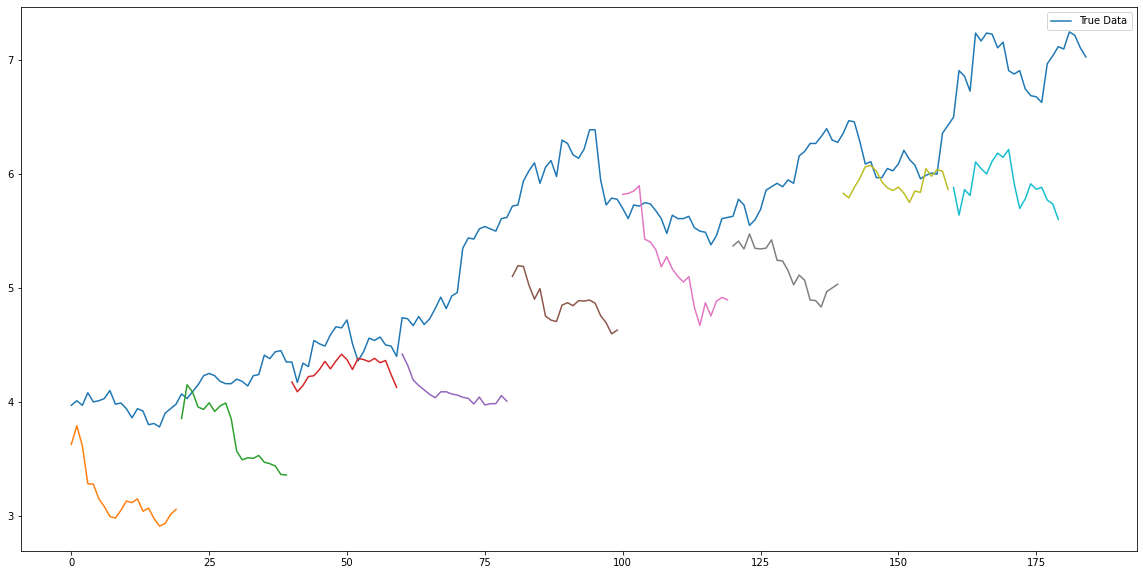

In [ ]:
import time
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
from numpy import newaxis
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
# from tensorflow.keras.layers import 
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

class conf:
    instrument = '601919.SH'  #股票代码
    #设置用于训练和回测的开始/结束日期
    start_date = '20180101'  
    end_date='20220425'
    field='close'
    seq_len=120 #每个input的长度
    prediction_len=20 #预测数据长度
    train_proportion=0.8 #训练数据占总数据量的比值，其余为测试数据
    normalise=True #数据标准化
    epochs  = 1 #LSTM神经网络迭代次数
    batch=100 #整数，指定进行梯度下降时每个batch包含的样本数,训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
    validation_split=0.1 # 0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。
    lr=0.001 #学习效率

def load_data(instrument,start_date,end_date,field,seq_len,prediction_len,train_proportion,normalise=True):
    # 加载数据，数据变化，提取数据模块
    fields=[field,'amount']
    ts.set_token('707823022ace77fbaa7bbed78fe1a5c8337bb28af9dbe0b7900ab517')
    pro = ts.pro_api()
    # data=D.history_data(instrument,start_date,end_date,fields)
    data = pro.daily(ts_code='601919.SH',start_date='20180101',end_date='20220425')
    print(data)
    data=data[data.amount>0]
    datetime=list(data['trade_date'])
    data=list(data[field])
    seq_len=seq_len+1  
    result=[]
    for index in range(len(data)-seq_len):
        result.append(data[index:index+seq_len])
        
    if normalise:
        norm_result=normalise_windows(result)
    else:
        norm_result=result
        
    result=np.array(result)
    norm_result=np.array(norm_result)
    
    row=round(train_proportion*norm_result.shape[0])
    
    data_test=result[int(row):,:]
    datetime=datetime[int(row):]

    test_datetime=[]
    for index in range(len(datetime)):
        if index % prediction_len==0 and index+seq_len<len(datetime)-prediction_len:
            test_datetime.append(datetime[index+seq_len])
    
    train=norm_result[:int(row),:]
    np.random.shuffle(train)   #随机打乱训练样本
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = norm_result[int(row):, :-1]
    y_test = norm_result[int(row):, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test, data_test, test_datetime]
    
def normalise_windows(window_data):
    #数据规范化
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def denormalise_windows(normdata,data,seq_len):
    #数据反规范化
    denormalised_data = []
    wholelen=0
    for i, rowdata in enumerate(normdata):
        denormalise=list()
        if isinstance(rowdata,float)|isinstance(rowdata,np.float32):
            denormalise = [(rowdata+1)*float(data[wholelen][0])]
            denormalised_data.append(denormalise)
            wholelen=wholelen+1
        else:       
            for j in range(len(rowdata)):
                denormalise.append((float(rowdata[j])+1)*float(data[wholelen][0]))
                wholelen=wholelen+1
            denormalised_data.append(denormalise)
    return denormalised_data

def build_model(layers):
    # LSTM神经网络层
    # 详细介绍请参考http://keras-cn.readthedocs.io/en/latest/
    model = Sequential()  

#     model.add(LSTM(input_dim=layers[0],output_dim=layers[1],return_sequences=True))
    model.add(LSTM(layers[1],input_shape=(layers[1],layers[0]),return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1],return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.add(Activation("linear"))

    rms=optimizers.RMSprop(lr=conf.lr, rho=0.9, epsilon=1e-06)
    model.compile(loss="mse", optimizer=rms)
    start = time.time()
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #每次只预测1步长
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, seq_len):
    #根据训练模型和第一段用来预测的时间序列长度逐步预测整个时间序列
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, seq_len, prediction_len):
    #根据训练模型和每段用来预测的时间序列长度逐步预测prediction_len长度的序列
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    #做图函数，用于predict_point_by_point和predict_sequence_full
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data)
    plt.legend()
    figure=plt.gcf()
    figure.set_size_inches(20,10)
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    #做图函数，用于predict_sequences_multiple
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)    
    plt.legend()
    figure=plt.gcf()
    figure.set_size_inches(20,10)
    plt.show()

#主程序
global_start_time = time.time() 

print('> Loading data... ')

X_train,y_train,X_test,y_test,data_test,test_datetime=load_data(conf.instrument,conf.start_date,conf.end_date,conf.field,conf.seq_len,conf.prediction_len,conf.train_proportion,normalise=True)

print('> Data Loaded. Compiling...')
print(X_train.shape)
model = build_model([1, conf.seq_len, 1])

model.fit(
    X_train,
    y_train,
    batch_size=conf.batch,
    epochs=conf.epochs,
    validation_split=conf.validation_split)


predictions = predict_sequences_multiple(model, X_test, conf.seq_len, conf.prediction_len)
# predictions = predict_sequence_full(model, X_test, conf.seq_len)
# predictions = predict_point_by_point(model, X_test)  
   
if conf.normalise==True:   
    predictions=denormalise_windows(predictions,data_test,conf.seq_len)
    y_test=denormalise_windows(y_test,data_test,conf.seq_len)

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, conf.prediction_len)
# plot_results(predictions, y_test)

